In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/")))

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.models import HierarchicalNormalSimulator
from src.python.helpers import get_repeated_predictions, get_preds_and_bfs
from src.python.visualization import (
    perf_tester,
    plot_calibration_curve_repetition_uncertainty,
)

import bayesflow as bf
import numpy as np
import pandas as pd
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up simulators

In [2]:
# Sample size
n_clusters = 50
n_obs = 50

In [3]:
# Generative models
normal_model = HierarchicalNormalSimulator()

m1_simulator = partial(
    normal_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs
)
m2_simulator = partial(
    normal_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs
)
meta_model = bf.simulation.MultiGenerativeModel([m1_simulator, m2_simulator])

# Set up networks

In [4]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_1']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_1']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_1']['dense_equiv_args']), 
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_2']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_2']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_2']['dense_equiv_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                   dense_args=probability_meta_validation['dense_args'], 
                                                   dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [5]:
# Training steps
epochs = 10
iterations_per_epoch = 1000


# Checkpoint path for loading pretrained network and saving the final network

checkpoint_path = "C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/01_calibration_validation/checkpoints_fixed"

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=meta_model,
    default_lr=0.0005,
    checkpoint_path=checkpoint_path,
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train & validate

In [6]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32
)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

# Validate

ECE = 0.017


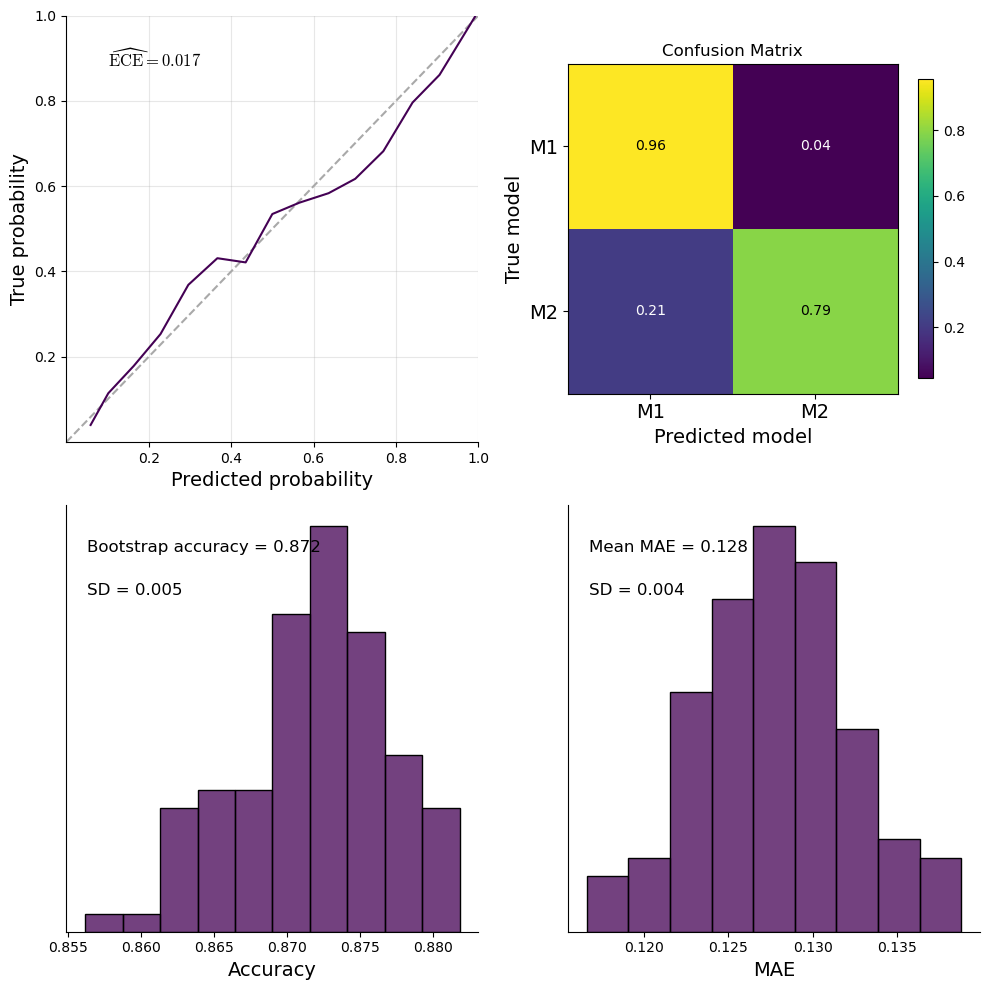

In [7]:
# Test performance
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

Median ECE = 0.014406239192187763
Median accuracy = 0.8858


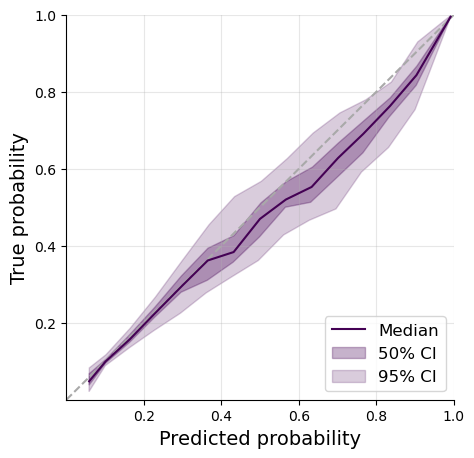

In [8]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
m_true_r, m_soft_r = get_repeated_predictions(
    probability_net,
    summary_net,
    trainer,
    meta_model,
    n_models=2,
    n_repetitions=n_repetitions,
)

plot_calibration_curve_repetition_uncertainty(
    m_true_r[:, :, 1],
    m_soft_r[:, :, 1],
    narrow_ci=[0.25, 0.75],
    wide_ci=[0.025, 0.975],
    n_bins=15,
    ax=ax,
    print_accuracy=True,
    xlabel=True,
    ylabel=True,
    title=None,
    show_ece=True,
    show_legend=True,
)

fig.savefig("calibration_fixed.pdf", dpi=300, bbox_inches="tight")

In [9]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = True

if save_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "01_fixed",
    )

    np.save(
        os.path.join(folder, "training_time_start"),
        training_time_start,
        allow_pickle=True,
    )
    np.save(
        os.path.join(folder, "training_time_stop"),
        training_time_stop,
        allow_pickle=True,
    )
    np.save(os.path.join(folder, "losses"), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [2]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = True

if import_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "01_fixed",
    )

    training_time_start = np.load(
        os.path.join(folder, "training_time_start.npy"), allow_pickle=True
    )
    training_time_stop = np.load(
        os.path.join(folder, "training_time_stop.npy"), allow_pickle=True
    )
    losses = np.load(os.path.join(folder, "losses.npy"), allow_pickle=True)

In [10]:
# Import test data
val_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())),
    "data",
    "02_bridge_sampling_comparison",
    "nested_models",
)
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [11]:
# Get NN predictions
comparison_results = get_preds_and_bfs(
    probability_net,
    summary_net,
    test_data,
    training_time_start,
    training_time_stop,
    losses,
)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.816915,0.183085,0,0.224117,329.320675,0.000399,0.298703
1,2,0,0.874769,0.125231,0,0.143158,329.320675,0.000399,0.298703
2,3,0,0.882417,0.117583,0,0.133251,329.320675,0.000399,0.298703
3,4,1,0.004943,0.995057,1,201.291116,329.320675,0.000399,0.298703
4,5,0,0.879558,0.120442,0,0.136935,329.320675,0.000399,0.298703


In [12]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime("%Y_%m_%d_BF_NN_fixed")
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())),
    "data",
    "02_bridge_sampling_comparison",
    "nested_models",
)

comparison_results.to_csv(os.path.join(comparison_folder, filename), index=False)